# Comparing three ML methods on flla dataset 

In [150]:
import os
import numpy as np
import pandas as pd
import ast
import pymatgen as pmg
import matplotlib.pyplot as plt

from matminer.datasets.dataframe_loader import load_flla
from matminer.featurizers.structure import SineCoulombMatrix
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.utils.conversions import str_to_composition

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

from pymatgen import MPRester

Import flla data

In [79]:
data = load_flla()
print ("Shape of data: ", data.shape)

Shape of data:  (3938, 7)


Convert string type `formula` for dict

In [80]:
data['formula'] = data['formula'].apply(lambda x: ast.literal_eval(x))

Obtain pymatgen composition object from dict type

In [81]:
data['composition'] = data['formula'].apply(lambda x: pmg.Composition(x))

## 1) Faber et al - Using Kernel Ridge Regression (KRR) on Sine Coulomb Matrix (SCM) featurization

Add sine coulomb matrix featurizer

In [136]:
scm = SineCoulombMatrix()
df_krr = scm.featurize_dataframe(data, col_id='structure')

Form vector descriptions using eigenvalues of SCMs

In [137]:
df_krr['sine coulomb matrix'] = pd.Series([np.sort(np.linalg.eigvals(s))[::-1] \
    for s in df_krr['sine coulomb matrix']], df_krr.index)

In [138]:
x = df_krr['sine coulomb matrix'].as_matrix()
y = df_krr['formation_energy_per_atom'].as_matrix()

Append each vector descriptor with zeros to make them all same size

In [139]:
nt = max(df_krr['nsites'])
XLIST = []
for i in range(len(x)):
    XLIST.append(np.append(x[i], np.zeros(nt - x[i].shape[0])))
x = np.array(XLIST)

Partition into training and testing set (80% training and 20% testing)

In [140]:
x_train_krr, x_test_krr, y_train_krr, y_test_krr = train_test_split(x, y, test_size=0.2, shuffle=True)

### Build ML model

Set up Kernel Ridge Regression model and use GridSearchCV to find best hyperparameter.

In [141]:
class KrrScm(KernelRidge):
    """
    Custom SCM KernelRidge estimator

    This estimator ensures that scores are based on formation
    energy per atom by dividing predicted and actual y values
    by the number of nonzero items in each row of the X matrix.
    This is equivalent to dividing by the number of sites in
    the corresponding structure because each vector descriptor
    is a list of eigenvalues of the SCM.  The SCM is positive
    definite, so its eigenvalues are positive.  This class only
    changes the results slightly, however, so the script can
    be simplified by replacing the SCM estimator below with a
    plain KernelRidge() instance.
    """

    def __init__(self, alpha=1, kernel='linear', gamma=None,
                 degree=3, coef0=1, kernel_params=None):
        super(KrrScm, self).__init__(alpha, kernel, gamma,
                                     degree, coef0, kernel_params)

    def score(self, X, y):
        sizes = np.array([self.length(row) for row in X])
        y_pred = self.predict(X) / sizes
        y_true = y / sizes
        return sklearn.metrics.r2_score(y_true, y_pred)

    def length(self, vec):
        return vec[vec != 0].shape[0]

In [142]:
krr = KrrScm()
params = {}
params['scm'] = [{'kernel' : ['rbf'], 'alpha' : [10**(-a) for a in range(2,6)],
    'gamma': [1/2.0/s/s for s in (20000,40000,80000,160000,320000)]},
    {'kernel' : ['laplacian'], 'alpha' : [10**(-a) for a in range(2,6)],
    'gamma' : [1.0/s for s in (20000,40000,80000,160000,320000)]}]

In [144]:
hpsel = GridSearchCV(krr, params['scm'], cv=KFold(5), refit=True)

Train KRR model using training set data

In [146]:
import warnings, sklearn
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    hpsel.fit(x_train_krr, y_train_krr)

Assign best hyperparameters to model

In [147]:
krr = hpsel.best_estimator_

Prediction data

In [148]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_test_krr = cross_val_predict(krr, x_test_krr, y_test_krr, cv=KFold(n_splits=5))

## 2) Ward et al (2016) - RandomForestRegressor on "general purpose" attributes  

Copy data into a new variable

In [82]:
df_ward2016 = data.copy()

Convert composition to pymatgen composition object 

In [83]:
df_ward2016['composition_obj'] = str_to_composition(df_ward2016['composition'])

Compute the features

In [84]:
ft = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                         cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])
df_ward2016 = ft.featurize_dataframe(df_ward2016, col_id='composition_obj', ignore_errors=True)

/Users/AikRui/anaconda3/lib/python3.6/site-packages/pymatgen/core/periodic_table.py:409: UserWarning:

No electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.

/Users/AikRui/anaconda3/lib/python3.6/site-packages/pymatgen/core/periodic_table.py:409: UserWarning:

No electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.



Remove entries with `NaN` or `infinite` features

In [85]:
original_count = len(df_ward2016)
df_ward2016 = df_ward2016.dropna()
print('Removed %d/%d entries'%(original_count - len(df_ward2016), original_count))

Removed 2/3938 entries


In [86]:
print ("Shape of featurized data: ", df_ward2016.shape)

Shape of featurized data:  (3936, 154)


#### Splitting dataset into training and testing dataset 

In [88]:
x = df_ward2016.drop(['material_id', 'e_above_hull', 'formula', 'nsites', 'structure', 'formation_energy', 'formation_energy_per_atom', 'composition', 'composition_obj'], 1)
y = df_ward2016['formation_energy_per_atom']

In [89]:
x_train_ward2016, x_test_ward2016, y_train_ward2016, y_test_ward2016 = train_test_split(x, y, test_size=0.2, shuffle=True)

### Build ML model

We will consider only Random Forest Regressor model. Here we fine tune the number of features used in each decision tree using GridSearchCV.

In [113]:
param = dict(max_features=(np.linspace(0.1, 1, 10)).tolist())
ward2016 = GridSearchCV(RandomForestRegressor(n_estimators=100),
                        param_grid=param,
                        scoring='neg_mean_squared_error',
                        cv=KFold(5))

Fit using training set

In [115]:
%%time
ward2016.fit(x_train_ward2016, y_train_ward2016)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

Save the best model

In [117]:
ward2016 = ward2016.best_estimator_

Predict testing data using model

In [118]:
cv_test_ward2016 = cross_val_predict(ward2016, x_test_ward2016, y_test_ward2016, cv=KFold(n_splits=5))

## 3) Ward et al (2017) - Voronoi-tessellation-based machine learning approach 

Since the featurization takes a long time, we import the featurized pickle file ready for processing

In [119]:
df_ward2017 = pd.read_pickle('./ward2017_featurized_data.pkl')

Splitting dataset into training and testing data

In [120]:
x = df_ward2017.drop(['material_id', 'e_above_hull', 'formula', 'nsites', 'structure', 'formation_energy', 'formation_energy_per_atom'], 1)
y = df_ward2017['formation_energy_per_atom']

In [124]:
x_train_ward2017, x_test_ward2017, y_train_ward2017, y_test_ward2017 = train_test_split(x, y, test_size=0.2, shuffle=True)

#### Train ML model (Random Forest Regressor) 

In [123]:
ward2017 = Pipeline([
    ('imputer', Imputer()), # For the failed structures
    ('model', RandomForestRegressor(n_estimators=100, n_jobs=-1))
])

In [125]:
%%time 
ward2017.fit(x_train_ward2017, y_train_ward2017)

CPU times: user 46.3 s, sys: 333 ms, total: 46.6 s
Wall time: 14.2 s


Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [126]:
cv_test_ward2017 = cross_val_predict(ward2017, x_test_ward2017, y_test_ward2017, cv=KFold(n_splits=5))

## Now we compare these three models 

In [134]:
KRR = {"mean_absolute_error": 0.0, "mean_squared_error": 0.0, "r2_score": 0.0}
WARD2016 = {"mean_absolute_error": 0.0, "mean_squared_error": 0.0, "r2_score": 0.0}
WARD2017 = {"mean_absolute_error": 0.0, "mean_squared_error": 0.0, "r2_score": 0.0}

In [149]:
for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
    KRR[scorer] = (getattr(metrics,scorer)(y_test_krr, cv_test_krr))
    WARD2016[scorer] = (getattr(metrics,scorer)(y_test_ward2016, cv_test_ward2016))
    WARD2017[scorer] = (getattr(metrics,scorer)(y_test_ward2017, cv_test_ward2017))

Plot predictions

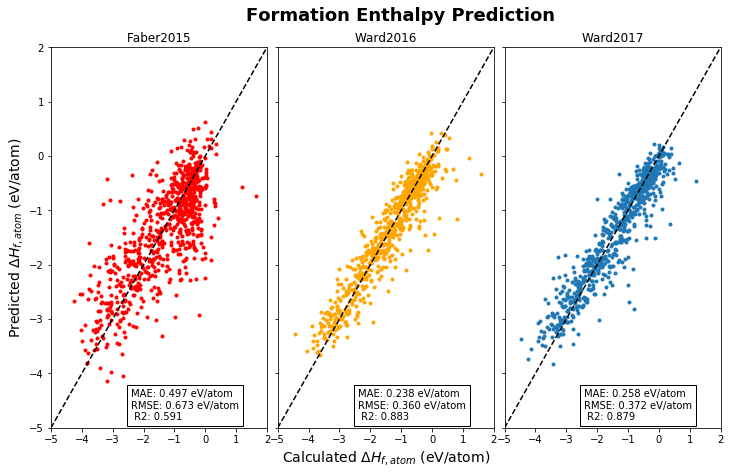

In [196]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, sharex=True)

ax1.set_xlim([-5, 2])
ax1.set_ylim([-5, 2])

fig.suptitle("Formation Enthalpy Prediction", fontsize=18, x=0.53, y=0.96, weight='bold')
ax1.set_ylabel("Predicted $\Delta H_{f, atom}$ (eV/atom)", fontsize=14)
ax2.set_xlabel("Calculated $\Delta H_{f, atom}$ (eV/atom)", fontsize=14)

ax1.set_title("Faber2015")
ax1.scatter(y_test_krr, cv_test_krr, marker='.', color='r')
ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')

ax2.set_title("Ward2016")
ax2.scatter(y_test_ward2016, cv_test_ward2016, marker='.', color='orange')
ax2.plot(ax2.get_xlim(), ax2.get_xlim(), 'k--')

ax3.set_title("Ward2017")
ax3.scatter(y_test_ward2017, cv_test_ward2017, marker='.')
ax3.plot(ax3.get_xlim(), ax3.get_xlim(), 'k--')

ax1.text(0.37, 0.02, 'MAE: {:.3f} eV/atom\nRMSE: {:.3f} eV/atom\n R2: {:.3f}'.format(KRR['mean_absolute_error'], np.sqrt(KRR['mean_squared_error']), KRR['r2_score']),
        transform=ax1.transAxes,
        bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax2.text(0.37, 0.02, 'MAE: {:.3f} eV/atom\nRMSE: {:.3f} eV/atom\n R2: {:.3f}'.format(WARD2016['mean_absolute_error'], np.sqrt(WARD2016['mean_squared_error']), WARD2016['r2_score']),
        transform=ax2.transAxes,
        bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax3.text(0.37, 0.02, 'MAE: {:.3f} eV/atom\nRMSE: {:.3f} eV/atom\n R2: {:.3f}'.format(WARD2017['mean_absolute_error'], np.sqrt(WARD2017['mean_squared_error']), WARD2017['r2_score']),
        transform=ax3.transAxes,
        bbox={'facecolor': 'w', 'edgecolor': 'k'})

fig.set_size_inches((12, 7))
fig.subplots_adjust(wspace=0.05)